In [1]:
### Importing relevant libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import transformers
from transformers import BertTokenizer
import numpy as np
import openai
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm import tqdm
from dotenv import load_dotenv
import os

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
import sys
print(sys.executable)

/Users/amaltom/.pyenv/versions/3.11.0/envs/madewithml/bin/python3.11


In [3]:
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [4]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [5]:
### Creating stratified sampling, so that the data splits have similar class distributions

test_size=0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=123)

In [6]:
train_df.tag.value_counts(ascending=True)

tag
mlops                           50
other                           85
computer-vision                228
natural-language-processing    248
Name: count, dtype: int64

In [7]:
val_df.tag.value_counts()

tag
natural-language-processing    62
computer-vision                57
other                          21
mlops                          13
Name: count, dtype: int64

### EDA

In [8]:
### Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

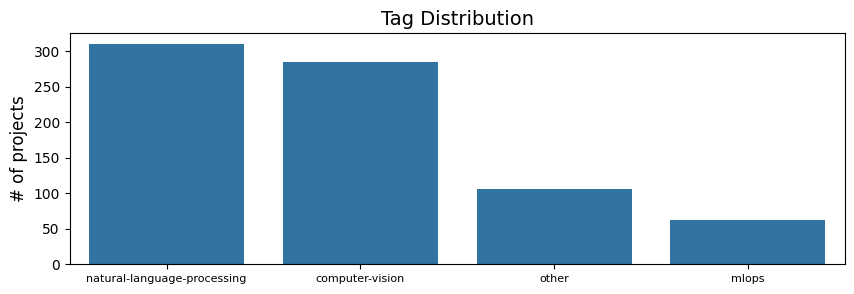

In [9]:
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10,3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag Distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

In [10]:
### WordCloud

def wordcloud(tag):
    tag = tag
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations=False, width = 500, height=300).generate(" ".join(text))
    return cloud 

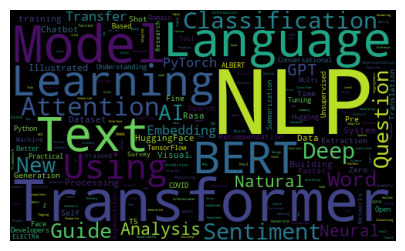

In [11]:
### Wordcloud for natural language processing

cloud = wordcloud("natural-language-processing")
plt.figure(figsize=(10,3))    
plt.axis('off')
plt.imshow(cloud)

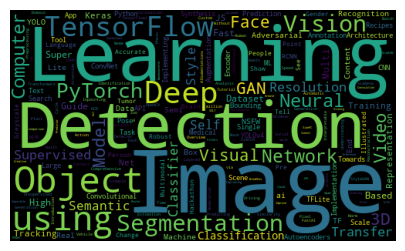

In [12]:
### Wordcloud for computer vision

cloud = wordcloud("computer-vision")
plt.figure(figsize=(10,3))    
plt.axis('off')
plt.imshow(cloud)

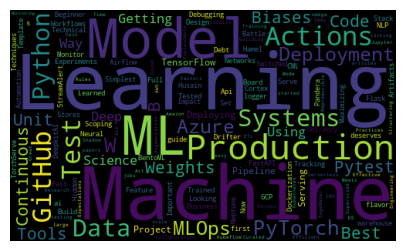

In [13]:
### Wordcloud for mlops

cloud = wordcloud("mlops")
plt.figure(figsize=(10,3))    
plt.axis('off')
plt.imshow(cloud)

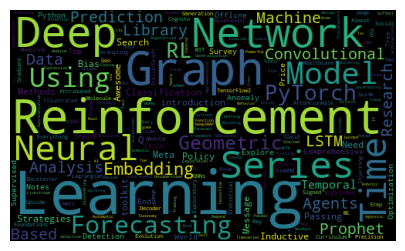

In [14]:
### Wordcloud for other

cloud = wordcloud("other")
plt.figure(figsize=(10,3))    
plt.axis('off')
plt.imshow(cloud)

#### Feature Engineering

In [15]:
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [16]:
df['text'] = df.title + " " +df.description

In [17]:
nltk.download('stopwords')
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amaltom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string"""
    # Lower 
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*" )
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text)
    text = re.sub(" +", " ", text)
    text = text.strip()
    text = re.sub(r"http\S+", "", text)

    return text

In [19]:
original_df = df.copy()
df['text_new'] = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.


In [20]:
df.head()

,id,created_on,title,description,tag,text,text_new
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,Comparison between YOLO and RCNN on real world...,comparison yolo rcnn real world videos bringin...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,"Show, Infer & Tell: Contextual Inference for C...",show infer tell contextual inference creative ...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other,Awesome Graph Classification A collection of i...,awesome graph classification collection import...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,Awesome Monte Carlo Tree Search A curated list...,awesome monte carlo tree search curated list m...
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other,"AttentionWalk A PyTorch Implementation of ""Wat...",attentionwalk pytorch implementation watch ste...


In [21]:
df.iloc[0]['title']

'Comparison between YOLO and RCNN on real world videos'

In [22]:
df.iloc[0]['description']

'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.'

In [23]:
df.iloc[0]['text']

'Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.'

In [24]:
### Dataframe cleanup 

df = df.drop(columns = ["id", "created_on","title","description"])
df = df.dropna(subset=["tag"])
df = df[["text_new","tag"]]
df.head()

,text_new,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [25]:
### Encoding 

tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [26]:
## Encode labels
df['tag'] = df['tag'].map(class_to_index)
df.head()

,text_new,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [27]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [28]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()['tag'].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

In [29]:
### Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors='np', padding='longest')

print('input_ids:', encoded_inputs["input_ids"])
print('attention_mask:', encoded_inputs["attention_mask"])
print(tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [30]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text_new"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [31]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}